<a href="https://colab.research.google.com/github/arnabbiswas66/multimodal-fake-news-classifier/blob/main/Weibo_multimodal_classifier_MHA_Luong_Regularized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install -q tensorflow_text

In [4]:
#!pip install -q talos

In [7]:
from tensorflow.python.platform.tf_logging import warn
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import re
from os import listdir
import shutil
import glob
import copy
import random
import matplotlib.pyplot as plt
#import talos as ta
import tensorflow_hub as hub
import tensorflow_text as text
#from official.nlp import optimization  # to create AdamW optimizer
tf.get_logger().setLevel('ERROR')
import warnings

warnings.filterwarnings('ignore')

## Initial Google Drive and Colab setup

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
BASE_SAVE_LOCATION = "/content/drive/MyDrive/multimodal-news"
CHECKPOINT_FILEPATH = '/content/drive/MyDrive/multimodal-news/weibo/'

In [10]:
# image copy pipeline from Gdrive to Colab
! mkdir "/content/images"
! cp "/content/drive/MyDrive/multimodal-news/weibo-data/images.zip" "/content/images"
! unzip -q -d "/content/images" "/content/images/images.zip"

## EDA

In [ ]:
def get_df(file):
    return pd.read_csv(file, sep='|',header = None)

In [ ]:
train_df_fake = get_df('/content/drive/MyDrive/multimodal-news/weibo-data/tweets/train_rumor.txt')
train_df_real = get_df('/content/drive/MyDrive/multimodal-news/weibo-data/tweets/train_nonrumor.txt')
test_df_fake = get_df('/content/drive/MyDrive/multimodal-news/weibo-data/tweets/test_rumor.txt')
test_df_real = get_df('/content/drive/MyDrive/multimodal-news/weibo-data/tweets/test_nonrumor.txt')

In [ ]:
train_df_fake.shape, train_df_real.shape, test_df_fake.shape, test_df_real.shape

((11194, 15), (11349, 15), (2934, 15), (2988, 15))

In [ ]:
train_fake = train_df_fake[0].tolist()
train_real = train_df_real[0].tolist()
test_fake = test_df_fake[0].tolist()
test_real = test_df_real[0].tolist()

In [ ]:
def fix_offset(list_):
    fixed_flag = False

    while not fixed_flag:
        exit_flag=False
        temp = copy.deepcopy(list_)
        for i,v in enumerate(temp):
            if v!=None:
                if 'sinaimg.cn' in v:
                    if list_[i+1] !=None:
                        if list_[i+1].isdigit():
                            list_.insert(i+1,None)
                            exit_flag=True
                            break
        if not exit_flag:
            fixed_flag=True
            
    return list_

In [ ]:
train_fake = fix_offset(train_fake) 
train_real = fix_offset(train_real)
test_fake = fix_offset(test_fake)
test_real = fix_offset(test_real)

In [ ]:
def break_in_block(list_):
    temp = []
    for i in range(0,len(list_),3):
        temp.append(list_[i:i+3])
    return temp

In [ ]:
train_fake = break_in_block(train_fake)
train_real = break_in_block(train_real)
test_fake = break_in_block(test_fake)
test_real = break_in_block(test_real)

In [ ]:
len(train_fake),len(train_real),len(test_fake),len(test_real)

(3748, 3783, 1000, 996)

In [ ]:
def get_image_and_text_list(blocks_list):
    image_list = []
    text_list = []
    for i in blocks_list:
        if i[-1] !=None:
            image_list.append(i[1])
            text_list.append(i[-1])
    image_list = [i.split('/')[-1] for i in image_list]
    return image_list, text_list

In [ ]:
train_fake_image,train_fake_text = get_image_and_text_list(train_fake)
train_real_image,train_real_text = get_image_and_text_list(train_real)
test_fake_image,test_fake_text = get_image_and_text_list(test_fake)
test_real_image,test_real_text = get_image_and_text_list(test_real)

In [ ]:
train_fake_Y = [0]*len(train_fake_image)
train_real_Y = [1]*len(train_real_image)
test_fake_Y = [0]*len(test_fake_image)
test_real_Y = [1]*len(test_real_image)

In [ ]:
train_images = train_fake_image+train_real_image
train_text = train_fake_text + train_real_text
trainY = train_fake_Y+train_real_Y

test_images = test_fake_image+test_real_image
test_text = test_fake_text+test_real_text
testY = test_fake_Y+test_real_Y

In [ ]:
len(train_images),len(train_text),len(trainY),len(test_images),len(test_text),len(testY)

(7481, 7481, 7481, 1930, 1930, 1930)

In [ ]:
train_images = np.array(train_images)
train_text = np.array(train_text)
trainY = np.array(trainY)
test_images = np.array(test_images)
test_text = np.array(test_text)
testY = np.array(testY)

In [ ]:
#!mv "/content/drive/MyDrive/multimodal-news/weibo-data/nonrumor_images/"* "/content/drive/MyDrive/multimodal-news/weibo-data/rumor_images"

In [ ]:
#!mv "/content/drive/MyDrive/multimodal-news/weibo-data/rumor_images" "/content/drive/MyDrive/multimodal-news/weibo-data/images"

In [ ]:
def index_to_delete(list_):
    list_images_dir = listdir('/content/images/images')
    gif_list = ['957e1cf2tw1e5foxts295g206o03p4qp.gif','a716fd45jw1ev0cgf8j46g209505zh4i.gif','005vnhZYgw1evupo8ttddg308w06o4qp.gif','7da75521gw1ele2jvi85rg2096056u0x.gif']
    index = []
    for i,v in enumerate(list_):
        if v not in list_images_dir:
            index.append(i)
        if v in gif_list:
            index.append(i)
    return index

In [ ]:
train_delete_index =index_to_delete(train_images)
test_delete_index = index_to_delete(test_images)
len(train_delete_index)+len(test_delete_index)

4147

In [ ]:
train_images = np.delete(train_images,train_delete_index)
train_text = np.delete(train_text,train_delete_index)
trainY = np.delete(trainY,train_delete_index)
test_images = np.delete(test_images,test_delete_index)
test_text = np.delete(test_text,test_delete_index)
testY = np.delete(testY,test_delete_index)

In [ ]:
shuffle_index= np.arange(len(train_images))
np.random.shuffle(shuffle_index)
train_images = train_images[shuffle_index]
train_text = train_text[shuffle_index]
trainY = trainY[shuffle_index]

In [ ]:
shuffle_index

array([3950, 2821,  749, ..., 1029, 2927,  527])

In [ ]:
len(train_images),len(train_text),len(trainY),len(test_images),len(test_text),len(testY)

(4140, 4140, 4140, 1124, 1124, 1124)

In [ ]:
# calculate the maximum document length
def max_length(lines):
    return max([len(s) for s in lines])

max len 498


(array([5.800e+02, 5.580e+02, 2.404e+03, 5.530e+02, 3.100e+01, 8.000e+00,
        4.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 498.]),
 <BarContainer object of 10 artists>)

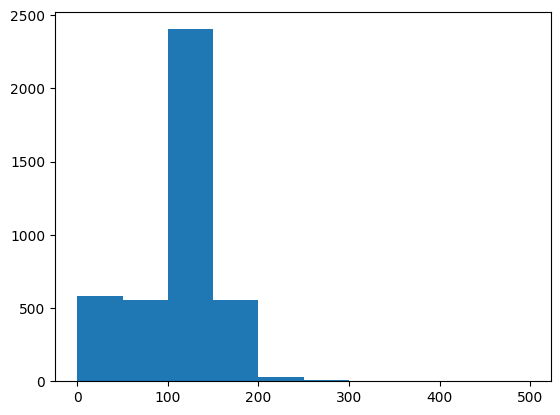

In [ ]:
print(f'max len {max_length(train_text)}')
plt.hist([len(s) for s in train_text],bins=[0,50,100,150,200,250,300,350,400,450,498])

In [ ]:
max_seq_length=200

In [ ]:
train_df = pd.DataFrame()
train_df['tweetText'] = pd.Series(train_text)
train_df['images_1'] = pd.Series(train_images)
train_df['label'] = pd.Series(trainY)
train_df.head()

,tweetText,images_1,label
0,#娱眼碌碌#【王思聪街头激吻广州模特】王思聪的我的网红女友系列又更新了一集，跟以往不同，终于...,593bbc68gw1ezf3efr9yrj20g3086gmt.jpg,1
1,【外媒：农行副总裁杨琨欠澳门赌债30亿人民币 】据路透社报道，中国农业银行副总裁杨琨欠澳门赌...,476b66c1jw1eoxdu4ypi8j20ci08c74n.jpg,0
2,我在看【寻人启示13759695559帮忙扩散!】，分享给你，快来看！ O寻人启示13759...,005N4ZWdjw1enz4806r0lj308c08ct9l.jpg,0
3,#求证# 据说第六套人民币增加1000，500，200面值，材质为塑料材质，类似于澳元。,715a7f5atw1e67kow32lyj20i80pctdf.jpg,0
4,#抗日战争胜利70周年9.3大阅兵#作为天津人！中国人！真要哭死了！真的已经无法当作新闻看了...,4e253b85jw1ev1geqx5gaj20ch0m8tah.jpg,0


In [ ]:
test_df = pd.DataFrame()
test_df['tweetText'] = pd.Series(test_text)
test_df['images_1'] = pd.Series(test_images)
test_df['label'] = pd.Series(testY)
test_df.head()

,tweetText,images_1,label
0,【郭美美申请低保，居然获准通过！】郭美美对记者说，她其实就是一个失业人员，并不是大家想象的那...,7fcc7edetw1e6btq03senj20c80gawgs.jpg,0
1,【看病要付钱只有二十几个国家】中国工程院院士戴勀戎：“看病就得付钱。在我们这里好像天经地义。...,8d5c03a7jw1e6r4cc7x02j20by0c40tt.jpg,0
2,东北证券吉林公主岭营业部今天上午被愤怒的股民点燃.,3dc2ac30jw1dx457fr1owj.jpg,0
3,【交通新规】归纳汇总为以下八条，开车的朋友请留意。2013年1月1日开始执行。@于建嵘 @海...,96449d00jw1dyupdyukbkj.jpg,0
4,隐翅虫,5103ab97gw1dwmttofzfoj.jpg,0


In [ ]:
IMAGE_DIR = '/content/images/images'

In [ ]:
def find_image_from_name_in_dir(image_name, dir):
  for name in glob.glob(dir+'/'+image_name):
    return name

In [ ]:
def visualise(index, df):
  path = IMAGE_DIR
  text = df.loc[index]['tweetText']
  image_path = find_image_from_name_in_dir(df.loc[index]['images_1'],path)
  image = plt.imread(image_path)
  plt.subplot(1, 1, 1)
  #plt.title('债券收益率')
  plt.title(text)
  plt.imshow(image)

# Visualize random tweets

3433


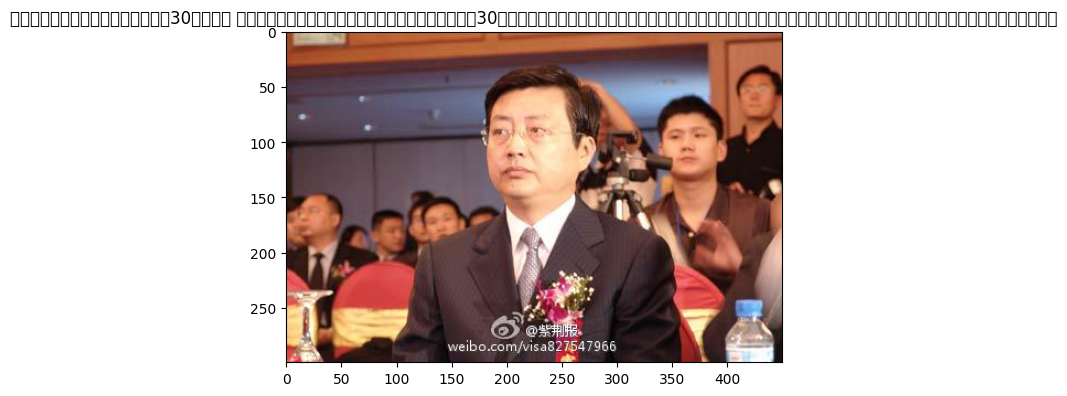

In [ ]:
indx = random.randint(0, len(train_df))
print(indx)
visualise(1, train_df)

In [ ]:
# Alternate dataframes for modeling
train_df_model = train_df[['tweetText', 'images_1', 'label']]
train_df_model['image_1'] = train_df_model['images_1'].apply(lambda x: find_image_from_name_in_dir(x, IMAGE_DIR))
train_df_model = train_df_model.drop(['images_1'], axis=1)
train_df_model.head(5)

,tweetText,label,image_1
0,#娱眼碌碌#【王思聪街头激吻广州模特】王思聪的我的网红女友系列又更新了一集，跟以往不同，终于...,1,/content/images/images/593bbc68gw1ezf3efr9yrj2...
1,【外媒：农行副总裁杨琨欠澳门赌债30亿人民币 】据路透社报道，中国农业银行副总裁杨琨欠澳门赌...,0,/content/images/images/476b66c1jw1eoxdu4ypi8j2...
2,我在看【寻人启示13759695559帮忙扩散!】，分享给你，快来看！ O寻人启示13759...,0,/content/images/images/005N4ZWdjw1enz4806r0lj3...
3,#求证# 据说第六套人民币增加1000，500，200面值，材质为塑料材质，类似于澳元。,0,/content/images/images/715a7f5atw1e67kow32lyj2...
4,#抗日战争胜利70周年9.3大阅兵#作为天津人！中国人！真要哭死了！真的已经无法当作新闻看了...,0,/content/images/images/4e253b85jw1ev1geqx5gaj2...


In [ ]:
# Check to make sure all the first_image_id are tied with a path
train_df_model[train_df_model['image_1'].isnull()]

,tweetText,label,image_1


In [ ]:
test_df_model = test_df[['tweetText', 'images_1', 'label']]
test_df_model['image_1'] = test_df_model['images_1'].apply(lambda x: find_image_from_name_in_dir(x, IMAGE_DIR))
test_df_model = test_df_model.drop(['images_1'], axis=1)
test_df_model.head(5)

,tweetText,label,image_1
0,【郭美美申请低保，居然获准通过！】郭美美对记者说，她其实就是一个失业人员，并不是大家想象的那...,0,/content/images/images/7fcc7edetw1e6btq03senj2...
1,【看病要付钱只有二十几个国家】中国工程院院士戴勀戎：“看病就得付钱。在我们这里好像天经地义。...,0,/content/images/images/8d5c03a7jw1e6r4cc7x02j2...
2,东北证券吉林公主岭营业部今天上午被愤怒的股民点燃.,0,/content/images/images/3dc2ac30jw1dx457fr1owj.jpg
3,【交通新规】归纳汇总为以下八条，开车的朋友请留意。2013年1月1日开始执行。@于建嵘 @海...,0,/content/images/images/96449d00jw1dyupdyukbkj.jpg
4,隐翅虫,0,/content/images/images/5103ab97gw1dwmttofzfoj.jpg


In [ ]:
# Check to make sure all the first_image_id are tied with a path
test_df_model[test_df_model['image_1'].isnull()]

,tweetText,label,image_1


In [ ]:
train_df_model['label'].value_counts()

0    3345
1     795
Name: label, dtype: int64

In [ ]:
test_df_model['label'].value_counts()

0    862
1    262
Name: label, dtype: int64

### Save the dataframes for faster access

In [ ]:
#Save training df
train_df_model.to_pickle(BASE_SAVE_LOCATION+"/weibo-train.pickle")
#Save testing df
test_df_model.to_pickle(BASE_SAVE_LOCATION+"/weibo-test.pickle")

## Load the dataframes

In [11]:
#Load training df
train_df_model = pd.read_pickle(BASE_SAVE_LOCATION+"/weibo-train.pickle")
#Load testing df
test_df_model = pd.read_pickle(BASE_SAVE_LOCATION+"/weibo-test.pickle")
print(train_df_model.shape, test_df_model.shape)

(4140, 3) (1124, 3)


In [12]:
# This is for Talos as it doesn't take TF DataSet as input
X_train = train_df_model.copy()
y_train = X_train.pop('label')

X_test = test_df_model.copy()
y_test = X_test.pop('label')

# Data input pipeline

In [13]:
# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = (
    "https://tfhub.dev/tensorflow/bert_zh_L-12_H-768_A-12/4"
)
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_zh_preprocess/3"

In [14]:
def make_bert_preprocessing_model(sentence_features, seq_length=128):
    """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: A list with the names of string-valued features.
    seq_length: An integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features
    ]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name="packer",
    )
    model_inputs = packer(truncated_segments)
    return keras.Model(input_segments, model_inputs)


In [15]:
bert_preprocess_model = make_bert_preprocessing_model(["text_1"], 224)
bert_preprocess_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_1 (InputLayer)         [(None,)]                 0         
                                                                 
 tokenizer (KerasLayer)      (None, None, None)        0         
                                                                 
 packer (KerasLayer)         {'input_word_ids': (None  0         
                             , 224),                             
                              'input_mask': (None, 22            
                             4),                                 
                              'input_type_ids': (None            
                             , 224)}                             
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [16]:
idx = np.random.choice(len(train_df_model))
row = train_df_model.iloc[idx]
sample_text_1, sample_text_2 = row["tweetText"], row["tweetText"]
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

test_text = [np.array([sample_text_1])]
text_preprocessed = bert_preprocess_model(test_text)

print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])


Text 1: 【现场视频：法国警方发动强攻击毙歹徒 民众抱头撤离】现场视频显示：法国警方发动了强攻，击毙2名歹徒，民众抱头撤离。。。L现场：法国警方发动强攻击毙歹徒 民众抱头撤离
Text 2: 【现场视频：法国警方发动强攻击毙歹徒 民众抱头撤离】现场视频显示：法国警方发动了强攻，击毙2名歹徒，民众抱头撤离。。。L现场：法国警方发动强攻击毙歹徒 民众抱头撤离
Keys           :  ['input_word_ids', 'input_mask', 'input_type_ids']
Shape Word Ids :  (1, 224)
Word Ids       :  tf.Tensor(
[ 101  523 4385 1767 6228 7574 8038 3791 1744 6356 3175 1355 1220 2487
 3122 1140], shape=(16,), dtype=int32)
Shape Mask     :  (1, 224)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 224)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [17]:
def dataframe_to_dataset(dataframe):
    columns = ['tweetText', 'image_1', 'label']
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

## Preprocessing utilities

In [18]:
resize = (224, 224)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]

In [19]:
def preprocess_image(image_path):
  extension = tf.strings.split(image_path,'.')[-1]
  image = tf.io.read_file(image_path)
  if extension == b"gif":
    image = tf.io.decode_image(image, 3, expand_animations=False)
  elif extension == b"png":
    image = tf.image.decode_png(image, 3)
  else:
    image = tf.image.decode_jpeg(image, 3)
  image = tf.image.resize(image, resize)
  return image

In [20]:
def preprocess_text(text_1):
  text_1 = tf.convert_to_tensor([text_1])
  output = bert_preprocess_model([text_1])
  output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
  return output

In [21]:
def preprocess_text_and_image(sample):
  image_1 = preprocess_image(sample["image_1"])
  text = preprocess_text(sample["tweetText"])
  return {"image_1": image_1, "text": text}

In [22]:
batch_size = 32
auto = tf.data.AUTOTUNE

In [23]:
def prepare_dataset(dataframe, training=True):
  ds = dataframe_to_dataset(dataframe)
  if training:
      ds = ds.shuffle(len(train_df_model))
  ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
  ds = ds.batch(batch_size).prefetch(auto)
  return ds

In [32]:
train_ds = prepare_dataset(train_df_model)
test_ds = prepare_dataset(test_df_model, False)

## Model Building

### Projection

In [24]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings


### Vision encoder

In [25]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.EfficientNetV2B3(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image_1")
    
    # Preprocess the input image.
    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(image_1)
    
    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings = resnet_v2(preprocessed_1)
    #embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])
    #print("Image embeddings shape before", embeddings.shape)
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    #print("Image embeddings shape After", outputs.shape)
    # Create the vision encoder model.
    return keras.Model([image_1], outputs, name="vision_encoder")

### Text Encoder

In [26]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(bert_model_path, name="bert",)
    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(224,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

### Multi Head Attention Layer

In [27]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [keras.layers.Dense(ff_dim, activation="relu"), keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, x, y, training):
        attn_output = self.att(x, y)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

## MultiModal model

In [28]:
def create_multimodal_model(
    num_projection_layers=0,
    projection_dims=224,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
    attention=False
):
    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image_1")
    
    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(224,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Create the encoders.
    vision_encoder = create_vision_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    vision_projections = vision_encoder([image_1])
    vision_projections = keras.layers.Dropout(dropout_rate)(vision_projections)
    text_projections = text_encoder(text_inputs)
    text_projections = keras.layers.Dropout(dropout_rate)(text_projections)
    
    # Cross-attention.
    if attention:
      transformer_block = TransformerBlock(projection_dims, 4, projection_dims)
      x = transformer_block(tf.expand_dims(vision_projections, -1), tf.expand_dims(text_projections, -1))
      x = tf.keras.layers.Flatten()(x)
      x = project_embeddings(
        x, 1, projection_dims, dropout_rate) 
      query_value_attention_seq = keras.layers.Attention(use_scale=True, dropout=0.2)(
            [vision_projections, text_projections]
        )
      
    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    if attention:
        concatenated = keras.layers.Concatenate()([concatenated, x, query_value_attention_seq])
        #x = tf.keras.layers.Flatten(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(concatenated)
    return keras.Model([image_1, text_inputs], outputs)

In [29]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics= [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

## Final Multimodal model

In [ ]:
def multimodal_model(X_train, y_train, X_test, y_test, params):
  train_ds = prepare_dataset(train_df_model)
  test_ds = prepare_dataset(test_df_model, False)
  model = create_multimodal_model(params['num_projection_layers'],
    params['projection_dims'],
    params['dropout_rate'],
    params['vision_trainable'],
    params['text_trainable'],
    params['attention'])
  model.compile(
    optimizer=tf.keras.optimizers.Adam(params['lr']), loss=loss, metrics=metrics
  )
  history = model.fit(
      train_ds, validation_data=test_ds, 
      epochs=params['epochs'], batch_size=params['batch_size'], 
      callbacks = [model_checkpoint_callback])
  return history, model
  

In [ ]:
params = {
    'num_projection_layers' : [0, 1],
    'projection_dims' : [128, 224],
    'dropout_rate' : [0.1, 0.2],
    'vision_trainable' : [False],
    'text_trainable' : [False],
    'attention' : [True],
    'lr' : [0.001, 0.01, 0.1],
    'epochs' : [10],
    'batch_size' : [32, 64]
}

In [ ]:
h = ta.Scan(x = X_train, y= y_train, params = params, model = multimodal_model, x_val = X_test, y_val = y_test, experiment_name = 'multi', save_weights=False, print_params=True)



  0%|          | 0/48 [00:00<?, ?it/s]

{'num_projection_layers': 0, 'projection_dims': 128, 'dropout_rate': 0.1, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.001, 'epochs': 10, 'batch_size': 32}


  0%|          | 0/48 [05:59<?, ?it/s]


Epoch 1/10
130/130 [==============================] - 124s 782ms/step - loss: 0.5274 - accuracy: 0.7879 - precision: 0.4695 - recall: 0.3542 - val_loss: 0.3534 - val_accuracy: 0.8434 - val_precision: 0.7867 - val_recall: 0.4504
Epoch 2/10
130/130 [==============================] - 101s 775ms/step - loss: 0.2877 - accuracy: 0.8729 - precision: 0.7066 - recall: 0.5786 - val_loss: 0.4049 - val_accuracy: 0.8336 - val_precision: 0.9032 - val_recall: 0.3206
Epoch 3/10
130/130 [==============================] - 102s 789ms/step - loss: 0.2711 - accuracy: 0.8857 - precision: 0.7307 - recall: 0.6415 - val_loss: 0.3122 - val_accuracy: 0.8683 - val_precision: 0.8239 - val_recall: 0.5534
Epoch 4/10
130/130 [==============================] - 102s 790ms/step - loss: 0.2517 - accuracy: 0.8932 - precision: 0.7496 - recall: 0.6667 - val_loss: 0.2909 - val_accuracy: 0.8737 - val_precision: 0.7830 - val_recall: 0.6336
Epoch 5/10
130/130 [==============================] - 103s 791ms/step - loss: 0.2403 - a



  2%|▏         | 1/48 [18:22<14:23:38, 1102.51s/it]

{'num_projection_layers': 0, 'projection_dims': 128, 'dropout_rate': 0.1, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.001, 'epochs': 10, 'batch_size': 64}
Epoch 1/10
130/130 [==============================] - 125s 795ms/step - loss: 0.4299 - accuracy: 0.8353 - precision: 0.6123 - recall: 0.4901 - val_loss: 0.4069 - val_accuracy: 0.8319 - val_precision: 0.8925 - val_recall: 0.3168
Epoch 2/10
130/130 [==============================] - 102s 782ms/step - loss: 0.2991 - accuracy: 0.8688 - precision: 0.6800 - recall: 0.5987 - val_loss: 0.3111 - val_accuracy: 0.8639 - val_precision: 0.7824 - val_recall: 0.5763
Epoch 3/10
130/130 [==============================] - 100s 772ms/step - loss: 0.2650 - accuracy: 0.8872 - precision: 0.7412 - recall: 0.6340 - val_loss: 0.3399 - val_accuracy: 0.8612 - val_precision: 0.8581 - val_recall: 0.4847
Epoch 4/10
130/130 [==============================] - 102s 787ms/step - loss: 0.2585 - accuracy: 0.8918 - precision: 0.7440 - 



  4%|▍         | 2/48 [37:20<14:21:27, 1123.65s/it]

{'num_projection_layers': 0, 'projection_dims': 128, 'dropout_rate': 0.1, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.01, 'epochs': 10, 'batch_size': 32}
Epoch 1/10
130/130 [==============================] - 127s 804ms/step - loss: 4.3898 - accuracy: 0.8049 - precision: 0.5145 - recall: 0.5052 - val_loss: 2.8855 - val_accuracy: 0.7918 - val_precision: 0.9118 - val_recall: 0.1183
Epoch 2/10
130/130 [==============================] - 102s 788ms/step - loss: 1.2567 - accuracy: 0.8338 - precision: 0.5682 - recall: 0.5610 - val_loss: 1.0772 - val_accuracy: 0.8505 - val_precision: 0.9123 - val_recall: 0.3969
Epoch 3/10
130/130 [==============================] - 102s 788ms/step - loss: 0.6366 - accuracy: 0.8618 - precision: 0.6446 - recall: 0.6252 - val_loss: 0.8417 - val_accuracy: 0.8470 - val_precision: 0.9245 - val_recall: 0.3740
Epoch 4/10
130/130 [==============================] - 101s 776ms/step - loss: 0.3650 - accuracy: 0.8819 - precision: 0.7056 - r



  6%|▋         | 3/48 [56:24<14:09:25, 1132.57s/it]

{'num_projection_layers': 0, 'projection_dims': 128, 'dropout_rate': 0.1, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.01, 'epochs': 10, 'batch_size': 64}
Epoch 1/10
130/130 [==============================] - 127s 809ms/step - loss: 7.4350 - accuracy: 0.7891 - precision: 0.4772 - recall: 0.5251 - val_loss: 3.9896 - val_accuracy: 0.7758 - val_precision: 0.9167 - val_recall: 0.0420
Epoch 2/10
130/130 [==============================] - 103s 791ms/step - loss: 1.3934 - accuracy: 0.8278 - precision: 0.5528 - recall: 0.5396 - val_loss: 1.4634 - val_accuracy: 0.8256 - val_precision: 0.9342 - val_recall: 0.2710
Epoch 3/10
130/130 [==============================] - 103s 792ms/step - loss: 0.5533 - accuracy: 0.8587 - precision: 0.6389 - recall: 0.6075 - val_loss: 0.3712 - val_accuracy: 0.8594 - val_precision: 0.8467 - val_recall: 0.4847
Epoch 4/10
130/130 [==============================] - 103s 792ms/step - loss: 0.3600 - accuracy: 0.8800 - precision: 0.6955 - r



  8%|▊         | 4/48 [1:14:53<13:43:43, 1123.27s/it]

{'num_projection_layers': 0, 'projection_dims': 128, 'dropout_rate': 0.1, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.1, 'epochs': 10, 'batch_size': 32}
Epoch 1/10
130/130 [==============================] - 127s 806ms/step - loss: 37.4439 - accuracy: 0.8116 - precision: 0.5323 - recall: 0.5061 - val_loss: 3.7456 - val_accuracy: 0.8496 - val_precision: 0.7104 - val_recall: 0.5992
Epoch 2/10
130/130 [==============================] - 102s 788ms/step - loss: 2.9709 - accuracy: 0.8447 - precision: 0.5943 - recall: 0.6025 - val_loss: 3.8809 - val_accuracy: 0.6708 - val_precision: 0.4025 - val_recall: 0.8511
Epoch 3/10
130/130 [==============================] - 102s 788ms/step - loss: 6.8824 - accuracy: 0.8464 - precision: 0.5961 - recall: 0.6201 - val_loss: 1.8061 - val_accuracy: 0.7883 - val_precision: 0.5438 - val_recall: 0.5687
Epoch 4/10
130/130 [==============================] - 102s 789ms/step - loss: 18.3900 - accuracy: 0.8408 - precision: 0.5819 - 



 10%|█         | 5/48 [1:32:39<13:10:12, 1102.62s/it]

{'num_projection_layers': 0, 'projection_dims': 128, 'dropout_rate': 0.1, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.1, 'epochs': 10, 'batch_size': 64}
Epoch 1/10
130/130 [==============================] - 127s 808ms/step - loss: 101.0008 - accuracy: 0.7827 - precision: 0.4642 - recall: 0.5336 - val_loss: 9.1495 - val_accuracy: 0.7936 - val_precision: 0.9167 - val_recall: 0.1260
Epoch 2/10
130/130 [==============================] - 103s 791ms/step - loss: 4.7109 - accuracy: 0.8343 - precision: 0.5684 - recall: 0.5698 - val_loss: 9.5340 - val_accuracy: 0.8470 - val_precision: 0.7009 - val_recall: 0.5992
Epoch 3/10
130/130 [==============================] - 102s 789ms/step - loss: 2.6020 - accuracy: 0.8534 - precision: 0.6196 - recall: 0.6126 - val_loss: 1.0267 - val_accuracy: 0.8594 - val_precision: 0.7080 - val_recall: 0.6756
Epoch 4/10
130/130 [==============================] - 102s 789ms/step - loss: 1.0880 - accuracy: 0.8703 - precision: 0.6658 - 



 12%|█▎        | 6/48 [1:50:46<12:48:17, 1097.56s/it]

{'num_projection_layers': 0, 'projection_dims': 128, 'dropout_rate': 0.2, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.001, 'epochs': 10, 'batch_size': 32}
Epoch 1/10
130/130 [==============================] - 128s 816ms/step - loss: 0.4896 - accuracy: 0.8129 - precision: 0.5504 - recall: 0.3718 - val_loss: 0.3926 - val_accuracy: 0.8319 - val_precision: 0.8411 - val_recall: 0.3435
Epoch 2/10
130/130 [==============================] - 103s 792ms/step - loss: 0.3068 - accuracy: 0.8679 - precision: 0.6902 - recall: 0.5660 - val_loss: 0.3248 - val_accuracy: 0.8630 - val_precision: 0.8214 - val_recall: 0.5267
Epoch 3/10
130/130 [==============================] - 103s 792ms/step - loss: 0.2584 - accuracy: 0.8889 - precision: 0.7431 - recall: 0.6440 - val_loss: 0.3030 - val_accuracy: 0.8612 - val_precision: 0.7409 - val_recall: 0.6221
Epoch 4/10
130/130 [==============================] - 103s 791ms/step - loss: 0.2463 - accuracy: 0.8971 - precision: 0.7610 - 



 15%|█▍        | 7/48 [2:08:39<12:24:24, 1089.38s/it]

{'num_projection_layers': 0, 'projection_dims': 128, 'dropout_rate': 0.2, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.001, 'epochs': 10, 'batch_size': 64}
Epoch 1/10
130/130 [==============================] - 128s 815ms/step - loss: 0.4488 - accuracy: 0.8338 - precision: 0.6091 - recall: 0.4806 - val_loss: 0.3941 - val_accuracy: 0.8416 - val_precision: 0.8621 - val_recall: 0.3817
Epoch 2/10
130/130 [==============================] - 103s 790ms/step - loss: 0.2936 - accuracy: 0.8756 - precision: 0.7128 - recall: 0.5899 - val_loss: 0.4500 - val_accuracy: 0.8390 - val_precision: 0.9355 - val_recall: 0.3321
Epoch 3/10
130/130 [==============================] - 102s 789ms/step - loss: 0.2661 - accuracy: 0.8872 - precision: 0.7419 - recall: 0.6327 - val_loss: 0.3475 - val_accuracy: 0.8621 - val_precision: 0.8639 - val_recall: 0.4847
Epoch 4/10
130/130 [==============================] - 103s 791ms/step - loss: 0.2421 - accuracy: 0.8993 - precision: 0.7708 - 



 17%|█▋        | 8/48 [2:27:08<12:10:26, 1095.66s/it]

{'num_projection_layers': 0, 'projection_dims': 128, 'dropout_rate': 0.2, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.01, 'epochs': 10, 'batch_size': 32}
Epoch 1/10
130/130 [==============================] - 128s 814ms/step - loss: 6.1143 - accuracy: 0.7958 - precision: 0.4911 - recall: 0.4702 - val_loss: 2.3446 - val_accuracy: 0.8052 - val_precision: 0.9057 - val_recall: 0.1832
Epoch 2/10
130/130 [==============================] - 101s 780ms/step - loss: 1.0292 - accuracy: 0.8408 - precision: 0.5881 - recall: 0.5711 - val_loss: 0.7730 - val_accuracy: 0.8461 - val_precision: 0.8112 - val_recall: 0.4427
Epoch 3/10
130/130 [==============================] - 102s 788ms/step - loss: 0.4602 - accuracy: 0.8691 - precision: 0.6712 - recall: 0.6239 - val_loss: 0.4895 - val_accuracy: 0.8541 - val_precision: 0.7130 - val_recall: 0.6260
Epoch 4/10
130/130 [==============================] - 102s 790ms/step - loss: 0.3352 - accuracy: 0.8831 - precision: 0.7121 - r



 19%|█▉        | 9/48 [2:45:30<11:53:28, 1097.65s/it]

{'num_projection_layers': 0, 'projection_dims': 128, 'dropout_rate': 0.2, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.01, 'epochs': 10, 'batch_size': 64}
Epoch 1/10
130/130 [==============================] - 128s 820ms/step - loss: 4.7034 - accuracy: 0.7996 - precision: 0.5010 - recall: 0.4541 - val_loss: 1.4947 - val_accuracy: 0.7731 - val_precision: 0.5077 - val_recall: 0.8817
Epoch 2/10
130/130 [==============================] - 103s 793ms/step - loss: 1.2918 - accuracy: 0.8403 - precision: 0.5842 - recall: 0.5849 - val_loss: 0.6464 - val_accuracy: 0.8185 - val_precision: 0.5863 - val_recall: 0.7519
Epoch 3/10
130/130 [==============================] - 103s 793ms/step - loss: 0.4560 - accuracy: 0.8703 - precision: 0.6711 - recall: 0.6365 - val_loss: 0.5511 - val_accuracy: 0.7785 - val_precision: 0.5142 - val_recall: 0.8969
Epoch 4/10
130/130 [==============================] - 103s 792ms/step - loss: 0.3681 - accuracy: 0.8734 - precision: 0.6795 - r



 21%|██        | 10/48 [3:03:23<11:30:22, 1090.06s/it]

{'num_projection_layers': 0, 'projection_dims': 128, 'dropout_rate': 0.2, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.1, 'epochs': 10, 'batch_size': 32}
Epoch 1/10
 14/130 [==>...........................] - ETA: 1:11 - loss: 306.8893 - accuracy: 0.8104 - precision: 0.5860 - recall: 0.5630

KeyboardInterrupt: ignored

In [ ]:
params = {
    'num_projection_layers' : [0],
    'projection_dims' : [224],
    'dropout_rate' : [0.1, 0.2],
    'vision_trainable' : [False],
    'text_trainable' : [False],
    'attention' : [True],
    'lr' : [0.001, 0.005],
    'epochs' : [10],
    'batch_size' : [32]
}

In [ ]:
h = ta.Scan(x = X_train, y= y_train, params = params, model = multimodal_model, x_val = X_test, y_val = y_test, experiment_name = 'multi', save_weights=True, print_params=True)

  0%|          | 0/4 [00:00<?, ?it/s]

{'num_projection_layers': 0, 'projection_dims': 224, 'dropout_rate': 0.1, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.001, 'epochs': 10, 'batch_size': 32}


  2%|▏         | 1/48 [3:12:19<150:39:39, 11539.98s/it]


Epoch 1/10
130/130 [==============================] - 126s 794ms/step - loss: 0.8962 - accuracy: 0.7873 - precision: 0.4682 - recall: 0.4204 - val_loss: 1.1604 - val_accuracy: 0.7678 - val_precision: 1.0000 - val_recall: 0.0038
Epoch 2/10
130/130 [==============================] - 103s 794ms/step - loss: 0.3692 - accuracy: 0.8553 - precision: 0.6408 - recall: 0.5610 - val_loss: 0.3556 - val_accuracy: 0.8568 - val_precision: 0.8301 - val_recall: 0.4847
Epoch 3/10
130/130 [==============================] - 103s 795ms/step - loss: 0.2924 - accuracy: 0.8778 - precision: 0.7061 - recall: 0.6226 - val_loss: 0.3165 - val_accuracy: 0.8648 - val_precision: 0.7865 - val_recall: 0.5763
Epoch 4/10
130/130 [==============================] - 104s 800ms/step - loss: 0.2861 - accuracy: 0.8802 - precision: 0.7091 - recall: 0.6377 - val_loss: 0.3134 - val_accuracy: 0.8710 - val_precision: 0.8000 - val_recall: 0.5954
Epoch 5/10
130/130 [==============================] - 104s 799ms/step - loss: 0.2678 - a

 25%|██▌       | 1/4 [18:44<56:13, 1124.51s/it]

{'num_projection_layers': 0, 'projection_dims': 224, 'dropout_rate': 0.1, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.005, 'epochs': 10, 'batch_size': 32}
Epoch 1/10
130/130 [==============================] - 131s 832ms/step - loss: 15.8833 - accuracy: 0.7812 - precision: 0.4561 - recall: 0.4664 - val_loss: 3.1761 - val_accuracy: 0.7669 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
130/130 [==============================] - 104s 802ms/step - loss: 1.6742 - accuracy: 0.8213 - precision: 0.5351 - recall: 0.5270 - val_loss: 6.2185 - val_accuracy: 0.7669 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
130/130 [==============================] - 104s 799ms/step - loss: 1.5851 - accuracy: 0.8360 - precision: 0.5740 - recall: 0.5660 - val_loss: 3.7009 - val_accuracy: 0.7678 - val_precision: 1.0000 - val_recall: 0.0038
Epoch 4/10
130/130 [==============================] - 104s 801ms/step - loss: 0.8494 - accuracy: 0.8529 - pre

 50%|█████     | 2/4 [36:50<36:43, 1101.91s/it]

{'num_projection_layers': 0, 'projection_dims': 224, 'dropout_rate': 0.2, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.001, 'epochs': 10, 'batch_size': 32}
Epoch 1/10
130/130 [==============================] - 131s 835ms/step - loss: 1.7496 - accuracy: 0.7859 - precision: 0.4671 - recall: 0.4702 - val_loss: 0.4713 - val_accuracy: 0.8158 - val_precision: 0.8161 - val_recall: 0.2710
Epoch 2/10
130/130 [==============================] - 104s 803ms/step - loss: 0.3586 - accuracy: 0.8522 - precision: 0.6376 - recall: 0.5333 - val_loss: 0.4191 - val_accuracy: 0.8488 - val_precision: 0.8286 - val_recall: 0.4427
Epoch 3/10
130/130 [==============================] - 104s 801ms/step - loss: 0.3531 - accuracy: 0.8674 - precision: 0.6704 - recall: 0.6088 - val_loss: 0.3385 - val_accuracy: 0.8523 - val_precision: 0.6846 - val_recall: 0.6794
Epoch 4/10
130/130 [==============================] - 104s 801ms/step - loss: 0.3200 - accuracy: 0.8800 - precision: 0.7052 - 

 75%|███████▌  | 3/4 [54:58<18:15, 1095.29s/it]

{'num_projection_layers': 0, 'projection_dims': 224, 'dropout_rate': 0.2, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.005, 'epochs': 10, 'batch_size': 32}
Epoch 1/10
 31/130 [======>.......................] - ETA: 1:02 - loss: 28.0519 - accuracy: 0.7472 - precision: 0.4349 - recall: 0.6311

KeyboardInterrupt: ignored

In [ ]:
params = {
    'num_projection_layers' : [1],
    'projection_dims' : [128, 224],
    'dropout_rate' : [0.1, 0.2],
    'vision_trainable' : [False],
    'text_trainable' : [False],
    'attention' : [True],
    'lr' : [0.001],
    'epochs' : [10],
    'batch_size' : [32, 64]
}

In [ ]:
h = ta.Scan(x = X_train, y= y_train, params = params, model = multimodal_model, x_val = X_test, y_val = y_test, experiment_name = 'multi2', save_weights=True, print_params=True)

  0%|          | 0/8 [00:00<?, ?it/s]

{'num_projection_layers': 1, 'projection_dims': 128, 'dropout_rate': 0.1, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.001, 'epochs': 10, 'batch_size': 32}
52606240/52606240 [==============================] - 2s 0us/step
Epoch 1/10
130/130 [==============================] - 134s 782ms/step - loss: 0.4959 - accuracy: 0.8176 - precision: 0.5361 - recall: 0.3736 - val_loss: 0.3524 - val_accuracy: 0.8363 - val_precision: 0.6773 - val_recall: 0.5687
Epoch 2/10
130/130 [==============================] - 99s 766ms/step - loss: 0.2852 - accuracy: 0.8829 - precision: 0.7293 - recall: 0.6201 - val_loss: 0.3431 - val_accuracy: 0.8523 - val_precision: 0.7759 - val_recall: 0.5153
Epoch 3/10
130/130 [==============================] - 101s 780ms/step - loss: 0.2515 - accuracy: 0.8978 - precision: 0.7548 - recall: 0.6931 - val_loss: 0.4322 - val_accuracy: 0.8470 - val_precision: 0.9327 - val_recall: 0.3702
Epoch 4/10
130/130 [==============================] - 102s 787

 12%|█▎        | 1/8 [18:03<2:06:23, 1083.39s/it]

{'num_projection_layers': 1, 'projection_dims': 128, 'dropout_rate': 0.1, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.001, 'epochs': 10, 'batch_size': 64}
Epoch 1/10
130/130 [==============================] - 129s 801ms/step - loss: 0.5178 - accuracy: 0.8220 - precision: 0.5661 - recall: 0.4863 - val_loss: 0.3262 - val_accuracy: 0.8550 - val_precision: 0.7324 - val_recall: 0.5954
Epoch 2/10
130/130 [==============================] - 102s 783ms/step - loss: 0.2903 - accuracy: 0.8829 - precision: 0.7253 - recall: 0.6277 - val_loss: 0.2994 - val_accuracy: 0.8701 - val_precision: 0.7929 - val_recall: 0.5992
Epoch 3/10
130/130 [==============================] - 100s 767ms/step - loss: 0.2626 - accuracy: 0.8928 - precision: 0.7441 - recall: 0.6730 - val_loss: 0.2881 - val_accuracy: 0.8808 - val_precision: 0.8441 - val_recall: 0.5992
Epoch 4/10
130/130 [==============================] - 101s 782ms/step - loss: 0.2371 - accuracy: 0.9070 - precision: 0.7871 - 

 25%|██▌       | 2/8 [36:28<1:49:35, 1095.99s/it]

{'num_projection_layers': 1, 'projection_dims': 128, 'dropout_rate': 0.2, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.001, 'epochs': 10, 'batch_size': 32}
Epoch 1/10
130/130 [==============================] - 127s 796ms/step - loss: 0.5116 - accuracy: 0.8260 - precision: 0.5882 - recall: 0.4447 - val_loss: 0.3435 - val_accuracy: 0.8452 - val_precision: 0.6419 - val_recall: 0.7595
Epoch 2/10
130/130 [==============================] - 101s 779ms/step - loss: 0.2864 - accuracy: 0.8821 - precision: 0.7241 - recall: 0.6239 - val_loss: 0.2989 - val_accuracy: 0.8683 - val_precision: 0.7545 - val_recall: 0.6450
Epoch 3/10
130/130 [==============================] - 102s 784ms/step - loss: 0.2668 - accuracy: 0.8874 - precision: 0.7401 - recall: 0.6377 - val_loss: 0.3558 - val_accuracy: 0.8488 - val_precision: 0.6329 - val_recall: 0.8359
Epoch 4/10
130/130 [==============================] - 103s 790ms/step - loss: 0.2385 - accuracy: 0.9017 - precision: 0.7725 - 

 38%|███▊      | 3/8 [55:27<1:32:58, 1115.71s/it]

{'num_projection_layers': 1, 'projection_dims': 128, 'dropout_rate': 0.2, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.001, 'epochs': 10, 'batch_size': 64}
Epoch 1/10
130/130 [==============================] - 128s 800ms/step - loss: 0.4848 - accuracy: 0.8233 - precision: 0.5775 - recall: 0.4475 - val_loss: 0.3604 - val_accuracy: 0.8452 - val_precision: 0.8667 - val_recall: 0.3969
Epoch 2/10
130/130 [==============================] - 100s 769ms/step - loss: 0.2854 - accuracy: 0.8797 - precision: 0.7174 - recall: 0.6164 - val_loss: 0.4112 - val_accuracy: 0.8345 - val_precision: 0.9130 - val_recall: 0.3206
Epoch 3/10
130/130 [==============================] - 102s 785ms/step - loss: 0.2688 - accuracy: 0.8923 - precision: 0.7447 - recall: 0.6679 - val_loss: 0.3936 - val_accuracy: 0.8425 - val_precision: 0.9048 - val_recall: 0.3626
Epoch 4/10
130/130 [==============================] - 103s 792ms/step - loss: 0.2515 - accuracy: 0.9014 - precision: 0.7662 - 

 50%|█████     | 4/8 [1:13:51<1:14:03, 1110.95s/it]

{'num_projection_layers': 1, 'projection_dims': 224, 'dropout_rate': 0.1, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.001, 'epochs': 10, 'batch_size': 32}
Epoch 1/10
130/130 [==============================] - 132s 811ms/step - loss: 0.8680 - accuracy: 0.8066 - precision: 0.5200 - recall: 0.4797 - val_loss: 0.3327 - val_accuracy: 0.8479 - val_precision: 0.7136 - val_recall: 0.5802
Epoch 2/10
130/130 [==============================] - 103s 792ms/step - loss: 0.3392 - accuracy: 0.8662 - precision: 0.6704 - recall: 0.5962 - val_loss: 0.3305 - val_accuracy: 0.8568 - val_precision: 0.6950 - val_recall: 0.6870
Epoch 3/10
130/130 [==============================] - 104s 800ms/step - loss: 0.2981 - accuracy: 0.8836 - precision: 0.7239 - recall: 0.6365 - val_loss: 0.3979 - val_accuracy: 0.8390 - val_precision: 0.6057 - val_recall: 0.8855
Epoch 4/10
130/130 [==============================] - 104s 804ms/step - loss: 0.2546 - accuracy: 0.8976 - precision: 0.7573 - 

 62%|██████▎   | 5/8 [1:32:34<55:46, 1115.63s/it]  

{'num_projection_layers': 1, 'projection_dims': 224, 'dropout_rate': 0.1, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.001, 'epochs': 10, 'batch_size': 64}
Epoch 1/10
130/130 [==============================] - 130s 802ms/step - loss: 0.9498 - accuracy: 0.8019 - precision: 0.5078 - recall: 0.4314 - val_loss: 0.4093 - val_accuracy: 0.8238 - val_precision: 0.5988 - val_recall: 0.7405
Epoch 2/10
130/130 [==============================] - 102s 789ms/step - loss: 0.3680 - accuracy: 0.8568 - precision: 0.6494 - recall: 0.5522 - val_loss: 0.5929 - val_accuracy: 0.7429 - val_precision: 0.4735 - val_recall: 0.9198
Epoch 3/10
130/130 [==============================] - 101s 780ms/step - loss: 0.3042 - accuracy: 0.8819 - precision: 0.7155 - recall: 0.6390 - val_loss: 0.3486 - val_accuracy: 0.8496 - val_precision: 0.6372 - val_recall: 0.8244
Epoch 4/10
130/130 [==============================] - 103s 793ms/step - loss: 0.2632 - accuracy: 0.8925 - precision: 0.7444 - 

 75%|███████▌  | 6/8 [1:51:13<37:12, 1116.46s/it]

{'num_projection_layers': 1, 'projection_dims': 224, 'dropout_rate': 0.2, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.001, 'epochs': 10, 'batch_size': 32}
Epoch 1/10
130/130 [==============================] - 132s 815ms/step - loss: 1.1284 - accuracy: 0.7907 - precision: 0.4753 - recall: 0.4096 - val_loss: 0.5303 - val_accuracy: 0.8345 - val_precision: 0.8455 - val_recall: 0.3550
Epoch 2/10
130/130 [==============================] - 103s 795ms/step - loss: 0.4183 - accuracy: 0.8543 - precision: 0.6433 - recall: 0.5421 - val_loss: 0.3852 - val_accuracy: 0.8390 - val_precision: 0.6364 - val_recall: 0.7214
Epoch 3/10
130/130 [==============================] - 104s 802ms/step - loss: 0.3322 - accuracy: 0.8746 - precision: 0.6944 - recall: 0.6201 - val_loss: 0.3554 - val_accuracy: 0.8568 - val_precision: 0.7563 - val_recall: 0.5687
Epoch 4/10
130/130 [==============================] - 124s 953ms/step - loss: 0.2938 - accuracy: 0.8928 - precision: 0.7468 - 

 88%|████████▊ | 7/8 [2:09:38<18:32, 1112.75s/it]

{'num_projection_layers': 1, 'projection_dims': 224, 'dropout_rate': 0.2, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.001, 'epochs': 10, 'batch_size': 64}
Epoch 1/10
130/130 [==============================] - 132s 812ms/step - loss: 1.0601 - accuracy: 0.7920 - precision: 0.4775 - recall: 0.3822 - val_loss: 0.5921 - val_accuracy: 0.7829 - val_precision: 0.9500 - val_recall: 0.0725
Epoch 2/10
130/130 [==============================] - 103s 794ms/step - loss: 0.3337 - accuracy: 0.8674 - precision: 0.6772 - recall: 0.5912 - val_loss: 0.4813 - val_accuracy: 0.8425 - val_precision: 0.9208 - val_recall: 0.3550
Epoch 3/10
130/130 [==============================] - 104s 801ms/step - loss: 0.2796 - accuracy: 0.8838 - precision: 0.7205 - recall: 0.6453 - val_loss: 0.4920 - val_accuracy: 0.8470 - val_precision: 0.8947 - val_recall: 0.3893
Epoch 4/10
130/130 [==============================] - 104s 804ms/step - loss: 0.2662 - accuracy: 0.8913 - precision: 0.7433 - 

100%|██████████| 8/8 [2:27:46<00:00, 1108.31s/it]


## Multimodal Model selection

The best balanced model seems to be the one with hyperparameters - num_projection_layers = 1, , 'projection_dims': 128, 'dropout_rate': 0.1, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.001, 'epochs': 10, 'batch_size': 64. Lets try to run the model

In [33]:
checkpoint_filepath = '/content/drive/MyDrive/multimodal-news/weibo-models/comb-model1-weights.{val_accuracy:.4f}-{val_loss:.2f}.hdf5'
save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [34]:
multimodal_model = create_multimodal_model(attention=True, num_projection_layers=1, projection_dims=128)

52606240/52606240 [==============================] - 0s 0us/step


### Model Training

In [35]:
epochs = 10
batch_size = 64

In [36]:
multimodal_model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)
history = multimodal_model.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size, callbacks=[save_model])

Epoch 1/10
65/65 [==============================] - 144s 2s/step - loss: 0.4679 - accuracy: 0.8210 - precision: 0.5637 - recall: 0.3006 - val_loss: 0.4083 - val_accuracy: 0.8167 - val_precision: 0.6867 - val_recall: 0.3931
Epoch 2/10
65/65 [==============================] - 104s 2s/step - loss: 0.3189 - accuracy: 0.8676 - precision: 0.7178 - recall: 0.5119 - val_loss: 0.3339 - val_accuracy: 0.8479 - val_precision: 0.7156 - val_recall: 0.5763
Epoch 3/10
65/65 [==============================] - 104s 2s/step - loss: 0.2637 - accuracy: 0.8831 - precision: 0.7411 - recall: 0.6013 - val_loss: 0.3200 - val_accuracy: 0.8585 - val_precision: 0.7441 - val_recall: 0.5992
Epoch 4/10
65/65 [==============================] - 104s 2s/step - loss: 0.2413 - accuracy: 0.8930 - precision: 0.7635 - recall: 0.6415 - val_loss: 0.3116 - val_accuracy: 0.8621 - val_precision: 0.7082 - val_recall: 0.6947
Epoch 5/10
65/65 [==============================] - 102s 2s/step - loss: 0.2289 - accuracy: 0.9027 - precisi

In [37]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

In [38]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)

In [39]:
y_pred = multimodal_model.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

18/18 [==============================] - 25s 1s/step
Accuracy == 0.8781138790035588
F1 == [0.9228169  0.71035941]
Precision == [0.89704272 0.79620853]
Recall == [0.95011601 0.64122137]


In [ ]:
multimodal_model.load_weights('/content/drive/MyDrive/multimodal-news/weibo-models/model1-weights.0.8808-0.30.hdf5')

In [ ]:
y_pred = multimodal_model.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

18/18 [==============================] - 20s 1s/step
Accuracy == 0.8807829181494662
F1 == [0.92236385 0.74329502]
Precision == [0.9212963  0.74615385]
Recall == [0.92343387 0.74045802]


## Some Other models

num_projection_layers': 1, 'projection_dims': 128, 'dropout_rate': 0.2, 'vision_trainable': False, 'text_trainable': False, 'attention': True, 'lr': 0.001, 'epochs': 10, 'batch_size': 32}

In [45]:
checkpoint_filepath = '/content/drive/MyDrive/multimodal-news/weibo-models/comb-model3-weights.{val_accuracy:.4f}-{val_loss:.2f}.hdf5'

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)



In [46]:
epochs = 10
batch_size1 = 32

In [47]:
multimodal_model2 = create_multimodal_model(attention=True, num_projection_layers=1, projection_dims=128, dropout_rate=0.1)

In [48]:
multimodal_model2.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics)
history = multimodal_model2.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size1, callbacks=[save_model])

Epoch 1/10
65/65 [==============================] - 134s 2s/step - loss: 0.4827 - accuracy: 0.8243 - precision: 0.6398 - recall: 0.2857 - val_loss: 0.4100 - val_accuracy: 0.8185 - val_precision: 0.6908 - val_recall: 0.4008
Epoch 2/10
65/65 [==============================] - 104s 2s/step - loss: 0.3432 - accuracy: 0.8621 - precision: 0.7044 - recall: 0.4855 - val_loss: 0.3596 - val_accuracy: 0.8336 - val_precision: 0.7273 - val_recall: 0.4580
Epoch 3/10
65/65 [==============================] - 103s 2s/step - loss: 0.2759 - accuracy: 0.8773 - precision: 0.7218 - recall: 0.5874 - val_loss: 0.3975 - val_accuracy: 0.8256 - val_precision: 0.5882 - val_recall: 0.8397
Epoch 4/10
65/65 [==============================] - 105s 2s/step - loss: 0.2595 - accuracy: 0.8889 - precision: 0.7452 - recall: 0.6403 - val_loss: 0.3373 - val_accuracy: 0.8505 - val_precision: 0.6556 - val_recall: 0.7557
Epoch 5/10
65/65 [==============================] - 105s 2s/step - loss: 0.2508 - accuracy: 0.8966 - precisi

In [49]:
y_pred = multimodal_model2.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

18/18 [==============================] - 25s 1s/step
Accuracy == 0.8754448398576512
F1 == [0.92090395 0.70711297]
Precision == [0.89757709 0.78240741]
Recall == [0.94547564 0.64503817]


The model above is the best performance we have got so far

In [51]:
checkpoint_filepath = '/content/drive/MyDrive/multimodal-news/weibo-models/comb-model4-weights.{val_accuracy:.4f}-{val_loss:.2f}.hdf5'

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [52]:
multimodal_model2 = create_multimodal_model(attention=True, num_projection_layers=1, projection_dims=224, dropout_rate=0.1)

In [53]:
multimodal_model2.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics)
history = multimodal_model2.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size1, callbacks=[save_model])

Epoch 1/10
65/65 [==============================] - 138s 2s/step - loss: 0.4926 - accuracy: 0.8315 - precision: 0.6328 - recall: 0.3832 - val_loss: 0.4004 - val_accuracy: 0.8292 - val_precision: 0.7160 - val_recall: 0.4427
Epoch 2/10
65/65 [==============================] - 106s 2s/step - loss: 0.3395 - accuracy: 0.8570 - precision: 0.6809 - recall: 0.4805 - val_loss: 0.3489 - val_accuracy: 0.8461 - val_precision: 0.7908 - val_recall: 0.4618
Epoch 3/10
65/65 [==============================] - 106s 2s/step - loss: 0.2859 - accuracy: 0.8821 - precision: 0.7372 - recall: 0.6000 - val_loss: 0.3211 - val_accuracy: 0.8550 - val_precision: 0.7592 - val_recall: 0.5534
Epoch 4/10
65/65 [==============================] - 106s 2s/step - loss: 0.2633 - accuracy: 0.8884 - precision: 0.7542 - recall: 0.6214 - val_loss: 0.3015 - val_accuracy: 0.8657 - val_precision: 0.7846 - val_recall: 0.5840
Epoch 5/10
65/65 [==============================] - 104s 2s/step - loss: 0.2447 - accuracy: 0.8981 - precisi

In [54]:
y_pred = multimodal_model2.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

18/18 [==============================] - 26s 1s/step
Accuracy == 0.8852313167259787
F1 == [0.92724196 0.72842105]
Precision == [0.90230516 0.81220657]
Recall == [0.95359629 0.66030534]


In [55]:
multimodal_model2.load_weights('/content/drive/MyDrive/multimodal-news/weibo-models/comb-model4-weights.0.8550-0.32.hdf5')
y_pred = multimodal_model2.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

18/18 [==============================] - 23s 1s/step
Accuracy == 0.854982206405694
F1 == [0.9091922 0.6401766]
Precision == [0.87459807 0.7591623 ]
Recall == [0.94663573 0.55343511]
